### Equation Discovery

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import argparse
from tqdm import tqdm
from tqdm.auto import tqdm as tqdma
from datasets.create_dataset import create_dataset
from models.create_model import create_model
from models.pinn_models import ParamClipper

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def main(config: argparse.Namespace):
    torch.manual_seed(42)
    device = torch.device('cpu')

    # Create dataset
    phys_config = {
        'n_dof' : config.n_dof,
        'system-type' : config.system_type
    }
    phases = ['train', 'val', 'test']
    full_dataset = create_dataset(phys_config, config.sequence_length)
    train_size = int(1.0 * len(full_dataset))  # training size
    val_size = int(0.0 * len(full_dataset))  # validation size
    test_size = int(0.0 * len(full_dataset))  # testing size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
    datasets = {
        'train': train_dataset,
        'val': val_dataset,
        'test': test_dataset,
        'full' : full_dataset
    }
    dataloaders = {
        x: DataLoader(dataset=datasets[x], batch_size=config.batch_size, shuffle=False if x == 'train' else False, num_workers=config.num_workers, pin_memory=True) for x in phases}

    # Create pinn model
    if config.out_channels != 2*config.n_dof:
        raise Exception("Number of network outputs does not match state vector of simulated model")
    pinn_config = {
        'n_dof' : config.n_dof,
        'phys_system_type' : config.phys_system_type,
        'system_discovery' : config.system_discovery,
        'm_' : config.m_,
        'c_' : config.c_,
        'k_' : config.k_,
        'kn_' : config.kn_,
        'alphas' : full_dataset.alphas,
        'param_norms' : {
            'm' : 1.0,
            'c' : 1.0,
            'k' : 10.0,
            'kn' : 10.0
        }
    }
    model = create_model(config.model_type, config.in_channels, config.latent_features, config.out_channels, config.sequence_length, pinn_config)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    model.set_switches(config.lambdas)
    clipper = ParamClipper()

    # set up plotting and printing
    fig, axs = plt.subplots(3, 1, figsize=(12,12))
    loss_hist = []
    loss_hist_sub = []
    print_step = 1000

    # Training loop
    epoch = 0
    model = model.to(device)
    for epoch in tqdm(range(config.num_epochs)):
        write_string = ''
        write_string += 'Epoch {}\n'.format(epoch)
        for phase in phases:
            phase_loss = 0.
            write_string += '\tPhase {}\n'.format(phase)
            if phase == 'train':
                model.train()
                plotting_data = {
                    'input' : torch.zeros((train_size * config.sequence_length)),
                    'observations' : torch.zeros((train_size * config.sequence_length, 2)),
                    'output' : torch.zeros((train_size * config.sequence_length, 2))
                }
            else:
                model.eval()
            for i, sample in enumerate(dataloaders[phase]):
                # This data parsing is specific to the dummy example and will have to be changed
                targets = sample[..., :2*config.n_dof].to(device).float().requires_grad_()
                inputs = sample[..., 2*config.n_dof].to(device).float().requires_grad_()
                force = sample[..., 2*config.n_dof+1:].to(device).float().requires_grad_()
                if phase == 'train':
                    optimizer.zero_grad()
                predictions = model(inputs)
                loss, losses, residuals = model.loss_func(config.lambdas, inputs, targets, inputs, force)
                if config.system_discovery:
                    write_string += '\tSystem Parameters:\tc - {:.4f} [{:.2f}]\tk - {:.4f} [{:.2f}]\tkn - {:.4f} [{:.2f}]\n'.format(
                        model.c_[0,0].item()*pinn_config['param_norms']['c'],
                        config.c_[0,0].item(),
                        model.k_[0,0].item()*pinn_config['param_norms']['k'],
                        config.k_[0,0].item(),
                        model.kn_[0,0].item()*pinn_config['param_norms']['kn'],
                        config.kn_[0,0].item())
                phase_loss += loss.item()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    model.apply(clipper)
                    loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
                    plotting_data['input'], ids = torch.sort(inputs.reshape(-1))
                    plotting_data['force'] = force.reshape(-1)[ids]
                    plotting_data['observations'] = targets.reshape(-1,2)[ids,:]
                    plotting_data['output'] = predictions.reshape(-1,2)[ids,:]
                    plotting_data['residuals'] = residuals['R_ode']

            write_string += '\tLoss {}\n'.format(phase_loss)
        
        if (epoch+1) % print_step == 0:
            
            axs[0].cla()
            axs[0].plot(plotting_data['input'].detach()*model.alpha_t,
                    plotting_data['output'][:,0].detach()*model.alpha_z[0],
                    label='pred')
            axs[0].plot(plotting_data['input'].detach()*model.alpha_t,
                        plotting_data['observations'][:,0].detach()*model.alpha_z[0],
                        label='obs')
            axs[0].legend()

            axs[1].cla()
            axs[1].plot(plotting_data['input'].detach()*model.alpha_t,
                        plotting_data['output'][:,1].detach()*model.alpha_z[1],
                        label='pred')
            axs[1].plot(plotting_data['input'].detach()*model.alpha_t,
                        plotting_data['observations'][:,1].detach()*model.alpha_z[1],
                        label='obs')
            axs[1].legend()

            loss_vec = torch.arange(epoch+1)
            loss_step = len(loss_hist) // int(10e3) + 1
            loss_vec = loss_vec[::loss_step]
            loss_hist_sub = loss_hist_sub + loss_hist[::loss_step]
            loss_hist = []
            axs[2].cla()
            axs[2].plot(loss_vec,loss_hist_sub)
            axs[2].legend(['obs', 'cc', 'ode', 'total'])
            axs[2].set_yscale('log')

            display.clear_output(wait=True)
            display.display(plt.gcf())
            tqdma.write(write_string)

    return model, predictions

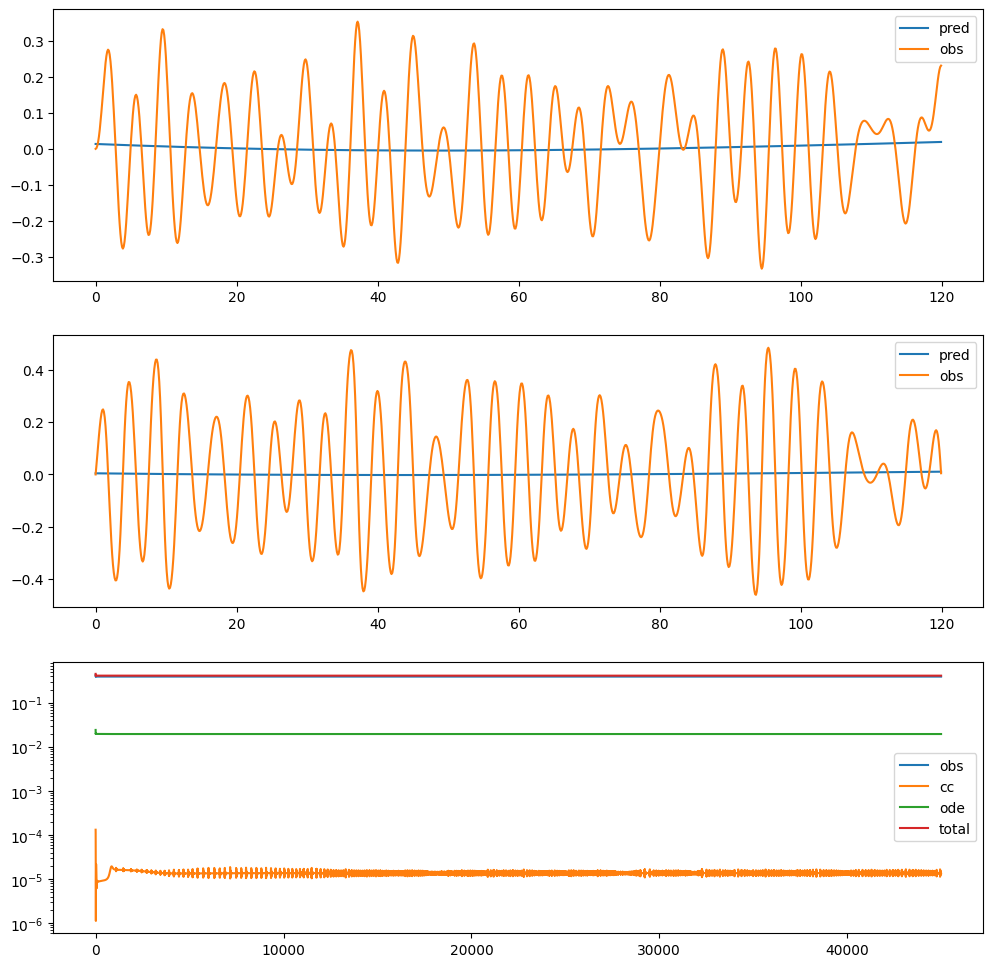

 23%|██▎       | 45018/200000 [05:49<1:26:43, 29.78it/s]

Epoch 44999
	Phase train
	System Parameters:	c - 0.0303 [1.00]	k - 7.7976 [15.00]	kn - 0.0034 [100.00]
	Loss 0.4155716598033905
	Phase val
	Loss 0.0
	Phase test
	Loss 0.0



 23%|██▎       | 45126/200000 [05:50<20:02, 128.77it/s] 


KeyboardInterrupt: 

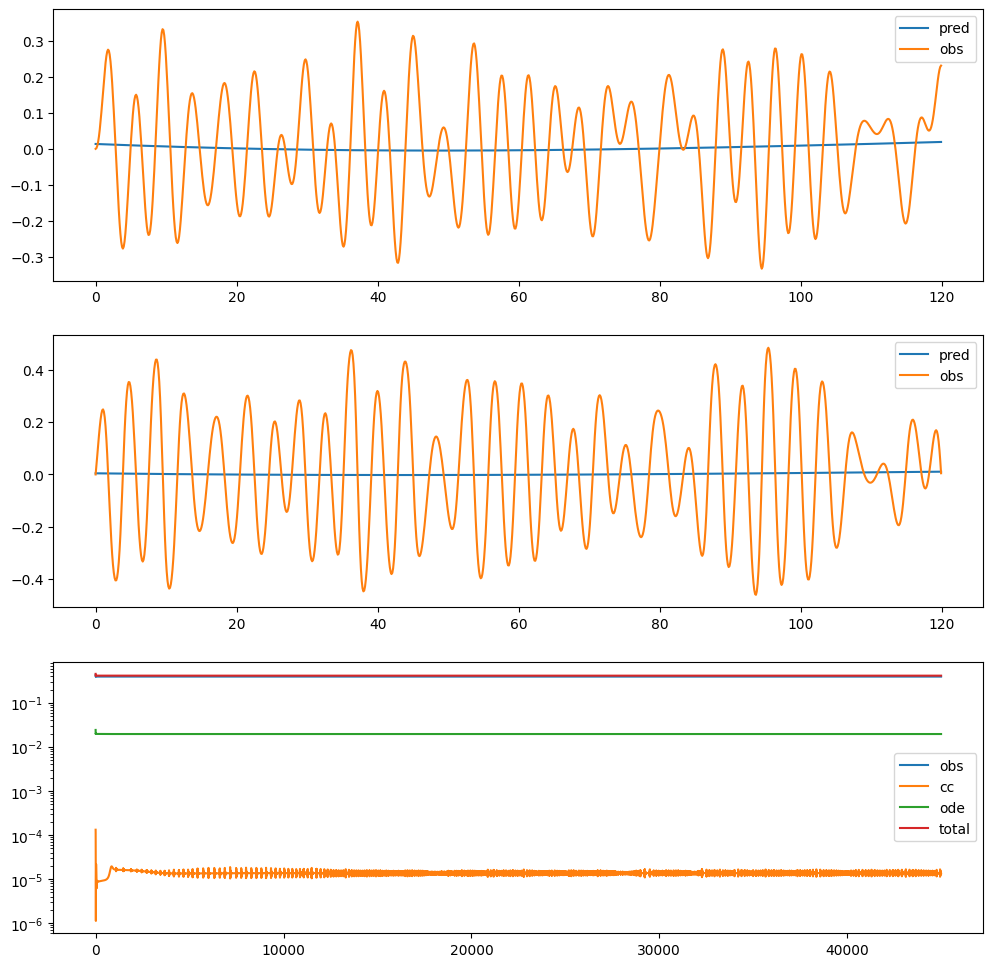

In [24]:
# parse config
parser = argparse.ArgumentParser(description="Train PINN")

# physical-model arguments
parser.add_argument('--n-dof', type=int, default=1)
parser.add_argument('--system-type', type=str, default='single_dof_duffing')

# nn-model arguments
parser.add_argument('--model-type', type=str, default='sdof_pinn')
parser.add_argument('--in-channels', type=int, default=1)
parser.add_argument('--latent-features', type=int, default=32)
parser.add_argument('--out-channels', type=int, default=2)

# pinn arguments
parser.add_argument('--phys-system-type', type=str, default='duffing_sdof')
parser.add_argument('--lambdas', type=dict, default={
    'obs' : 1.0,
    'cc' : 1.0,
    'ode' : 1.0
})
parser.add_argument('--system-discovery', type=bool, default=True)
parser.add_argument('--m-', type=torch.Tensor, default=torch.Tensor([[10.0]]))
parser.add_argument('--c-', type=torch.Tensor, default=torch.Tensor([[1.0]]))
parser.add_argument('--k-', type=torch.Tensor, default=torch.Tensor([[15.0]]))
parser.add_argument('--kn-', type=torch.Tensor, default=torch.Tensor([[100.0]]))

# training arguments
parser.add_argument('--batch-size', type=int, default=1024)
parser.add_argument('--num-workers', type=int, default=0)
parser.add_argument('--num-epochs', type=int, default=200000)
parser.add_argument('--sequence-length', type=int, default=1)
parser.add_argument('--learning-rate', type=float, default=1e-3)
parser.add_argument('--weight-decay', type=float, default=1e-4)

args = parser.parse_args(args=[])

model, predictions = main(args)